In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import numpy as np
from transformers import AutoTokenizer, ModernBertForSequenceClassification
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm

In [8]:
# 设置随机种子以确保结果可复现
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

In [9]:

set_seed(3407)

In [10]:
# 加载数据集
dataset=load_dataset('json',data_files='/root/for_may_conference/remake/data_for_train_bert_need_shuffle.json')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'score'],
        num_rows: 78200
    })
})

In [11]:
# 数据集随机打乱
shuffled_dataset = dataset["train"].shuffle(seed=3407)

In [12]:
train_test_split = shuffled_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

In [13]:
train_test_split = train_dataset.train_test_split(test_size=0.05)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [2]:

# 1. 加载保存的模型和tokenizer
model_path = "./final_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = ModernBertForSequenceClassification.from_pretrained(model_path)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [3]:
# 将模型设置为评估模式
model.eval()

# 如果有GPU可用，将模型移至GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(151680, 768, padding_idx=151646)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152

In [4]:
model.device

device(type='cuda', index=0)

In [ ]:
tokenized_test = tokenized_test.map(
    lambda x: {"label": x["score"]},  # 将 score 改名为 label
    remove_columns=["label"]         # 删除旧的 label 字段
)

In [20]:
# 3. 批量预测函数
def batch_predict(dataset, batch_size=32):
    all_predictions = []
    all_labels = []
    
    # 创建DataLoader以批量处理数据
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]
        
        # 获取文本和标签
        texts = batch["text"]  # 假设文本字段名为"text"
        labels = batch["score"]  # 假设标签字段名为"label"
        
        # 对文本进行编码
        inputs = tokenizer(texts, padding="max_length", truncation=True, 
                          max_length=8912, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # 预测
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = outputs.logits.squeeze().cpu().numpy()
        
        # 确保预测值在0-1范围内
        predictions = np.clip(predictions, 0, 1)
        
        # 存储预测结果和标签
        all_predictions.extend(predictions if isinstance(predictions, np.ndarray) else [predictions])
        all_labels.extend(labels)
    
    return np.array(all_predictions), np.array(all_labels)

In [21]:

# 4. 进行批量预测
predictions, true_labels = batch_predict(test_dataset)

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [02:06<00:00,  1.15s/it]


In [22]:
predictions

array([0.33562738, 0.48859456, 0.88700306, ..., 0.14091146, 0.48007455,
       0.19497699], dtype=float32)

In [25]:
true_labels

array([0.29011421, 0.4462907 , 0.90797428, ..., 0.78020292, 0.52476597,
       0.13964177])

In [26]:
# 5. 评估模型性能
mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)
correlation = np.corrcoef(predictions, true_labels)[0, 1]

print(f"测试集评估结果:")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"R² 分数: {r2:.4f}")
print(f"相关系数: {correlation:.4f}")

测试集评估结果:
均方误差 (MSE): 0.0114
平均绝对误差 (MAE): 0.0805
R² 分数: 0.8578
相关系数: 0.9267


/tmp/ipykernel_3033113/1305963251.py:12: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_3033113/1305963251.py:12: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_3033113/1305963251.py:12: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_3033113/1305963251.py:12: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_3033113/1305963251.py:12: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_3033113/1305963251.py:12: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp

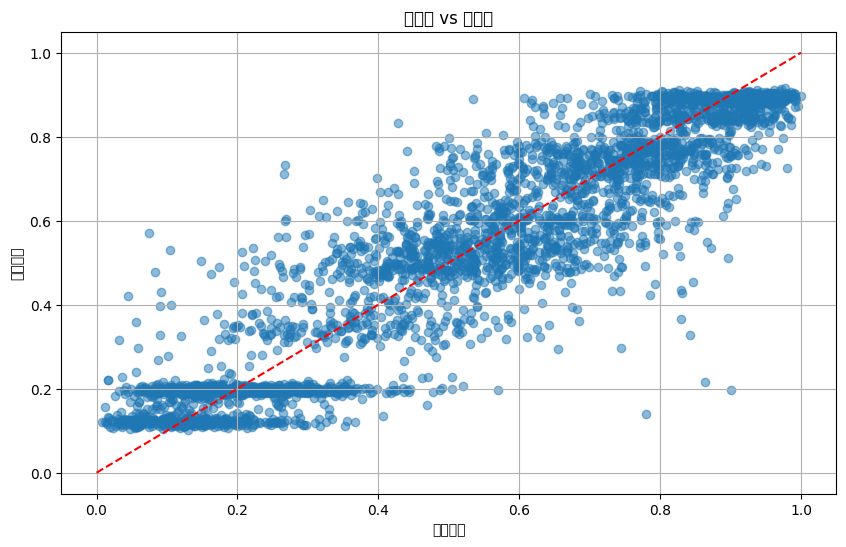

In [27]:
# 6. 可视化预测结果与真实标签的对比
plt.figure(figsize=(10, 6))

# 散点图：预测值 vs 真实值
plt.scatter(true_labels, predictions, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # 理想情况下的对角线

plt.xlabel('真实标签')
plt.ylabel('预测标签')
plt.title('预测值 vs 真实值')
plt.grid(True)
plt.savefig('prediction_vs_true.png')
plt.show()

/tmp/ipykernel_3033113/759105230.py:9: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_3033113/759105230.py:9: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_3033113/759105230.py:9: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_3033113/759105230.py:9: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_3033113/759105230.py:9: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_3033113/759105230.py:9: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_3

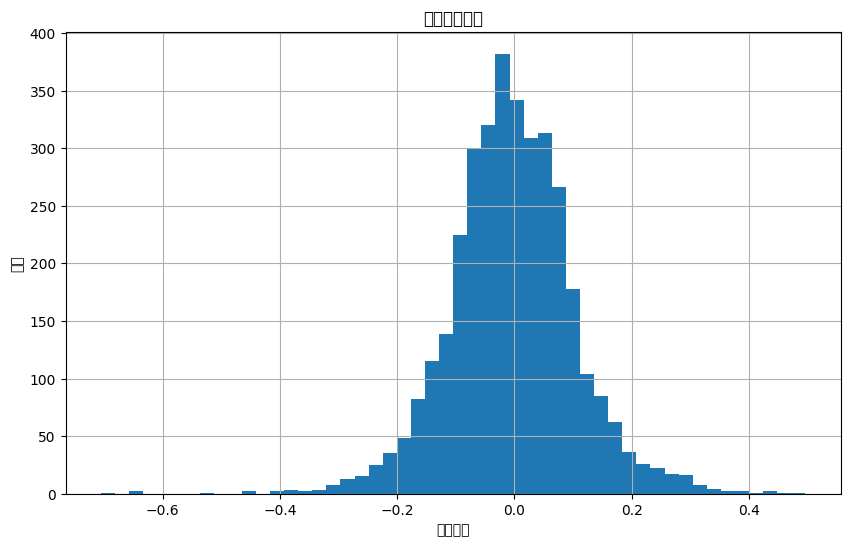

In [28]:
# 7. 误差分析
errors = predictions - true_labels
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.title('预测误差分布')
plt.grid(True)
plt.savefig('error_distribution.png')
plt.show()

In [32]:
# 8. 输出详细的预测结果（可选）
# 创建一个包含文本、真实标签和预测标签的DataFrame
results_df = pd.DataFrame({
    'text': test_dataset["text"],
    'true_label': true_labels,
    'predicted_label': predictions,
    'error': errors,
    'labels': test_dataset["label"]
})
results_df

,text,true_label,predicted_label,error,labels
0,冬奥8K转播背后的广东力量\n由广东科技企业研制的首款国产8K 50P小型化广播级摄像机参与...,0.290114,0.335627,0.045513,科学
1,"共模线圈线圈中的自感电动势总是与线圈中的电流变化抗.共模线圈对交流电流有阻碍作用,阻碍作用的...",0.446291,0.488595,0.042304,科学
2,中华人民共和国交通运输部令2018年第37号《交通运输部关于修改〈民用航空器驾驶员合格审定规...,0.907974,0.887003,-0.020971,政务
3,"""脱贫攻坚本来就是一场硬仗,而深度贫困地区脱贫攻坚是这场硬仗中的硬仗.我们务必深刻认识深度贫...",0.911156,0.757070,-0.154086,时政
4,"随着高新技术在军事上的广泛应用,使战争更具突发性,战争环境更加恶劣.在现代战争的人一机一环境...",0.470596,0.378374,-0.092222,科学
...,...,...,...,...,...
3514,3月31日，国家主席习近平在华盛顿会议中心会见美国总统奥巴马。新华社记者谢环驰摄当地时间3月...,0.900696,0.895002,-0.005695,政务
3515,"本文意译""Making Economic Sense""书中的""Eisnerizing Man...",0.158369,0.178420,0.020051,娱乐
3516,"编剧陈彤:""平凡之路""写给涉世未深的年轻人\n中青报·中青网记者 沈杰群\n ""给我创作带...",0.780203,0.140911,-0.639291,法律
3517,"从2022年初教育部工作要点明确提出""实施教育数字化战略行动"",到三月教育部发布国家智慧教育...",0.524766,0.480075,-0.044691,教育


In [35]:

# 按误差绝对值排序，查看最大误差的样本
results_df['abs_error'] = np.abs(errors)
sorted_results = results_df.sort_values('abs_error', ascending=False)

print("\n预测误差最大的10个样本:")
for i, row in sorted_results.head(10).iterrows():
    print(f"文本: {row['text'][:100]}...")
    print(f"真实标签: {row['true_label']:.4f}, 预测标签: {row['predicted_label']:.4f},原本分类: {row['labels']}")
    print(f"误差: {row['error']:.4f}\n")


预测误差最大的10个样本:
文本: 中国广播电视音像资料馆,即中国中央电视台广播电视音像资料馆,是中央电视台的直属部门,是中央电视台内容资产的归口管理部门,是支持我台节目制播,满足节目制作需求,实现节目资料资源共享的管理平台,是服务社会...
真实标签: 0.9012, 预测标签: 0.1960,原本分类: 新闻
误差: -0.7051

文本: [readpay]3[/readpay]
...
真实标签: 0.8642, 预测标签: 0.2157,原本分类: 政府工作报告
误差: -0.6485

文本: 编剧陈彤:"平凡之路"写给涉世未深的年轻人
中青报·中青网记者 沈杰群
  "给我创作带来灵感的是生活."作家,编剧陈彤接受中青报·中青网记者采访时说.
  为了笔下所写的剧情不"悬浮",在创作"平凡...
真实标签: 0.7802, 预测标签: 0.1409,原本分类: 法律
误差: -0.6393

文本: 发表权并不属于著作财产权,相反,发表权是属于著作人身权的一类,该权利由作者享有,不可转让,剥夺和限制.
著作财产权又称"著作经济权",是著作人身权的对称,指作者及传播者通过某种形式使用作品,从而依法获...
真实标签: 0.8427, 预测标签: 0.3288,原本分类: 法律
误差: -0.5139

文本: 中新网4月23日电 据最高检官方网站消息,中国煤炭科工集团有限公司原党委书记、董事长王金华涉嫌受贿一案,经中央纪委国家监委指定,由重庆市监察委员会立案调查,调查终结后,移送重庆市人民检察院审查起诉。经...
真实标签: 0.0746, 预测标签: 0.5706,原本分类: 其它
误差: 0.4960

文本: 全面建成小康社会,进而实现中华民族伟大复兴的中国梦,必须依靠知识,必须依靠劳动,必须依靠广大青年.广大知识分子,广大劳动群众,广大青年要紧跟时代,肩负使命,锐意进取,把自身的前途命运同国家和民族的前途...
真实标签: 0.2674, 预测标签: 0.7321,原本分类: 科学
误差: 0.4647

文本: [浦江之声]发展"包容性"数字经济,助力乡村振兴和共同富裕
中国式现代化的重要内涵之一,是实现共同富裕的现代化.数字经济的快速发展为推进乡村振兴和实现共同富裕提供了重大契机,但我们也应该清醒地认识到,...
真实标签: 0.8292

In [ ]:
sorted_results


不同标签区间的MSE:
0-0.2: 0.0069
0.2-0.4: 0.0150
0.4-0.6: 0.0136
0.6-0.8: 0.0126
0.8-1.0: 0.0097


/tmp/ipykernel_3033113/2696104827.py:23: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_3033113/2696104827.py:23: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_3033113/2696104827.py:23: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_3033113/2696104827.py:23: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_3033113/2696104827.py:23: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_3033113/2696104827.py:23: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_3

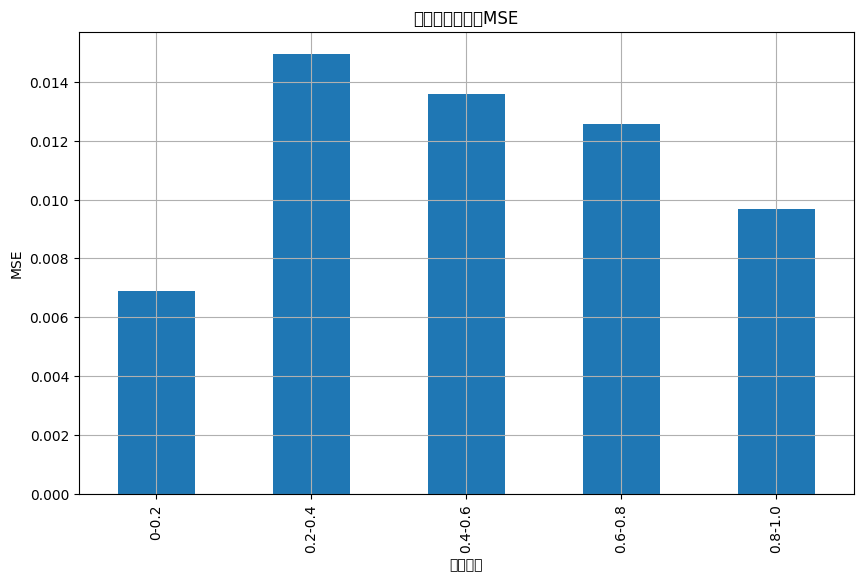

In [34]:
# 10. 分析不同标签区间的性能（可选）
# 将标签分成几个区间，查看模型在不同区间的表现
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
results_df['label_bin'] = pd.cut(results_df['true_label'], bins=bins, labels=bin_labels)

# 计算每个区间的MSE
bin_mse = results_df.groupby('label_bin').apply(
    lambda x: mean_squared_error(x['true_label'], x['predicted_label'])
)

print("\n不同标签区间的MSE:")
for bin_name, mse_value in bin_mse.items():
    print(f"{bin_name}: {mse_value:.4f}")

# 可视化不同区间的MSE
plt.figure(figsize=(10, 6))
bin_mse.plot(kind='bar')
plt.xlabel('标签区间')
plt.ylabel('MSE')
plt.title('不同标签区间的MSE')
plt.grid(True)
plt.savefig('mse_by_label_bin.png')
plt.show()